# Comparison of Discriminative Model and Manual QDA with a Single Gaussian Distribution

## Introduction
In this notebook, we explore the performance of a discriminative model and a manually implemented Quadratic Discriminant Analysis (QDA) on data generated from a single Gaussian distribution. We will compare their decision boundaries and evaluate their misclassification errors across different sample sizes.

---

## Imports and Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.optim.lr_scheduler import StepLR
import math

## Data Generation from a Single Gaussian Distribution
We will generate data from a single Gaussian distribution. The data will be used to train both a discriminative model and a manually implemented QDA.

In [3]:
def generate_data(n_samples, dim=2):
    # Generate X from a Gaussian distribution
    Mu_true = torch.tensor([0.0, 0.0])
    cov_true = torch.tensor([[3.0, 1.0], [1.0, 3.0]], dtype=torch.float32)
    dist = MultivariateNormal(Mu_true, cov_true)
    x = dist.sample((n_samples,))
    
    # Generate random upper triangular matrix M
    M = torch.triu(torch.randn(dim, dim))
    
    # Compute A as M * M^T
    A_True = torch.mm(M, M.t())
    
    # Generate random B (vector) and c (scalar)
    B_True = torch.randn(dim, 1)
    
    # Calculate the quadratic form for the classifier
    term1 = torch.sum((x @ A_True) * x, dim=1)
    term2 = (x @ B_True).squeeze()
    c_True = -torch.mean(term1 + term2)
    y = torch.sign(term1 + term2 + c_True)
    
    return x, y, A_True, B_True, c_True

## Manual Quadratic Discriminant Analysis (QDA) Implementation
We define a custom class `ManualQDA` to implement QDA from scratch. The `fit` method estimates the parameters from the data, and the `predict` method uses these parameters to classify new data points.

In [5]:
class ManualQDA:
    def __init__(self):
        self.A = None
        self.B = None
        self.c = None

    def fit(self, x, y):
        class_1 = x[y == 1]
        class_2 = x[y == -1]
        mu_1 = torch.mean(class_1, axis=0)
        mu_2 = torch.mean(class_2, axis=0)
        Sigma_1 = torch.cov(class_1.T)
        Sigma_2 = torch.cov(class_2.T)
        Sigma_1_inv = torch.inverse(Sigma_1)
        Sigma_2_inv = torch.inverse(Sigma_2)

        self.A = 0.5*(Sigma_1_inv - Sigma_2_inv)
        self.B = (Sigma_2_inv @ mu_2 - Sigma_1_inv @ mu_1).T
        self.c = 0.5*(mu_1.T @ Sigma_1_inv @ mu_1 - mu_2.T @ Sigma_2_inv @ mu_2 + torch.logdet(Sigma_1) - torch.logdet(Sigma_2))

    def decision_function(self, x):
        quad_form = torch.sum((x @ self.A) * x, dim=1)
        linear_form = torch.matmul(x, self.B)
        const_term = self.c
        decision_scores = quad_form + linear_form + const_term
        return decision_scores

    def predict(self, x):
        scores = self.decision_function(x)
        return -torch.sign(scores)

## Discriminative Model Training
Here we define a function to train a discriminative model using PyTorch. This model will learn the parameters A, B, and C directly from the data.

In [6]:
def train_discriminative_model(x, y, epochs=100, batch_size=64):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)

    A = torch.zeros((2, 2), requires_grad=True)
    B = torch.zeros((2, 1), requires_grad=True)
    C = torch.zeros(1, requires_grad=True)
    optimizer = torch.optim.Adam([A, B, C], lr=0.01)
    scheduler = StepLR(optimizer, step_size=25, gamma=0.1)
    error_history = []

    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            yhat = torch.sum((batch_x @ A) * batch_x, dim=1) + (batch_x @ B + C).squeeze()
            loss = torch.mean(torch.log(1 + torch.exp(-batch_y * yhat)))
            loss.backward()
            optimizer.step()
        
        scheduler.step()

        with torch.no_grad():
            yhat = torch.sum((x @ A) * x, dim=1) + (x @ B + C).squeeze()
            predictions = torch.sign(yhat)
            misclassification_error = (predictions != y).float().mean().item()
            error_history.append(misclassification_error)

    return A, B, C, error_history

## Model Evaluation Function
This function evaluates the performance of the discriminative model by calculating the misclassification error.

In [7]:
def evaluate_model(x, y, A, B, C):
    with torch.no_grad():
        yhat = torch.sum((x @ A) * x, dim=1) + (x @ B + C).squeeze()
        predictions = torch.sign(yhat)
        misclassification_error = (predictions != y).float().mean().item()
    return misclassification_error

## Manual QDA Training and Evaluation
This function trains the `ManualQDA` model on the training data and evaluates it on both the training and test datasets.

In [8]:
def train_and_evaluate_manual_qda(x_train, y_train, x_test, y_test):
    qda = ManualQDA()
    qda.fit(x_train, y_train)

    y_pred_train = qda.predict(x_train)
    error_train = (y_pred_train != y_train).float().mean().item()

    y_pred_test = qda.predict(x_test)
    error_test = (y_pred_test != y_test).float().mean().item()

    return error_train, error_test

## Decision Boundary Plotting
We will plot the decision boundaries for the QDA, discriminative model, and the true decision boundary calculated from the true parameters A and B.

In [9]:
def plot_decision_boundaries(qda_model, disc_model, x, y, A_True, B_True, title="Comparison of Decision Boundaries"):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=400), np.linspace(y_min, y_max, num=400))
    mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    Z_qda = qda_model.decision_function(mesh_points)
    Z_qda = Z_qda.reshape(xx.shape)

    model_outputs = disc_model(mesh_points).detach().numpy()
    Z_disc = model_outputs.reshape(xx.shape)

    Z_true = torch.sum((mesh_points @ A_True) * mesh_points, dim=1) + torch.matmul(mesh_points, B_True).squeeze() + c_True
    Z_true = Z_true.detach().numpy().reshape(xx.shape)

    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.contourf(xx, yy, Z_qda, levels=[-1, 0, 1], cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, Z_qda, levels=[0], colors='k', linestyles='--')
    plt.scatter(x[:, 0], x[:, 1], c=-y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.title(f"QDA - {title}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.subplot(1, 3, 2)
    plt.contourf(xx, yy, Z_disc, levels=[-1, 0, 1], cmap=plt.cm.viridis, alpha=0.5)
    plt.contour(xx, yy, Z_disc, levels=[0], cmap="RdBu_r")
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.viridis, s=20, edgecolors='k')
    plt.title(f"Discriminative - {title}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.subplot(1, 3, 3)
    plt.contourf(xx, yy, Z_true, levels=[-1, 0, 1], cmap=plt.cm.Pastel1, alpha=0.8)
    plt.contour(xx, yy, Z_true, levels=[0], colors='k', linestyles='--')
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Pastel1, s=20, edgecolors='k')
    plt.title(f"True - {title}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

## Simulation Across Different Sample Sizes
Simulations across different sample sizes to evaluate the performance of the discriminative model and QDA. For each sample size, average misclassification error on both the training and test datasets has been calculated.

C:\Users\yhcho\AppData\Local\Temp\ipykernel_7920\1992467026.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  self.B = (Sigma_2_inv @ mu_2 - Sigma_1_inv @ mu_1).T


Plotting decision boundaries for sample size 100


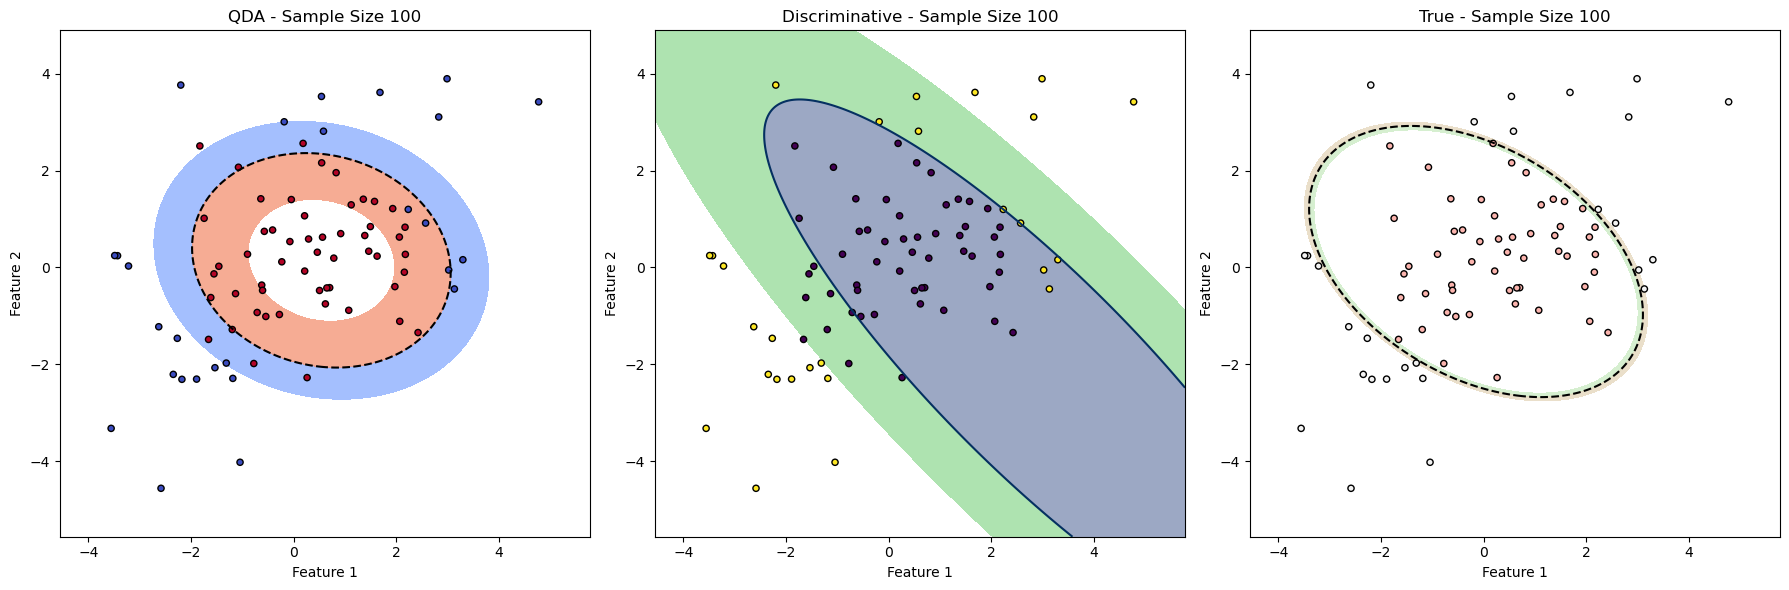

Plotting decision boundaries for sample size 200


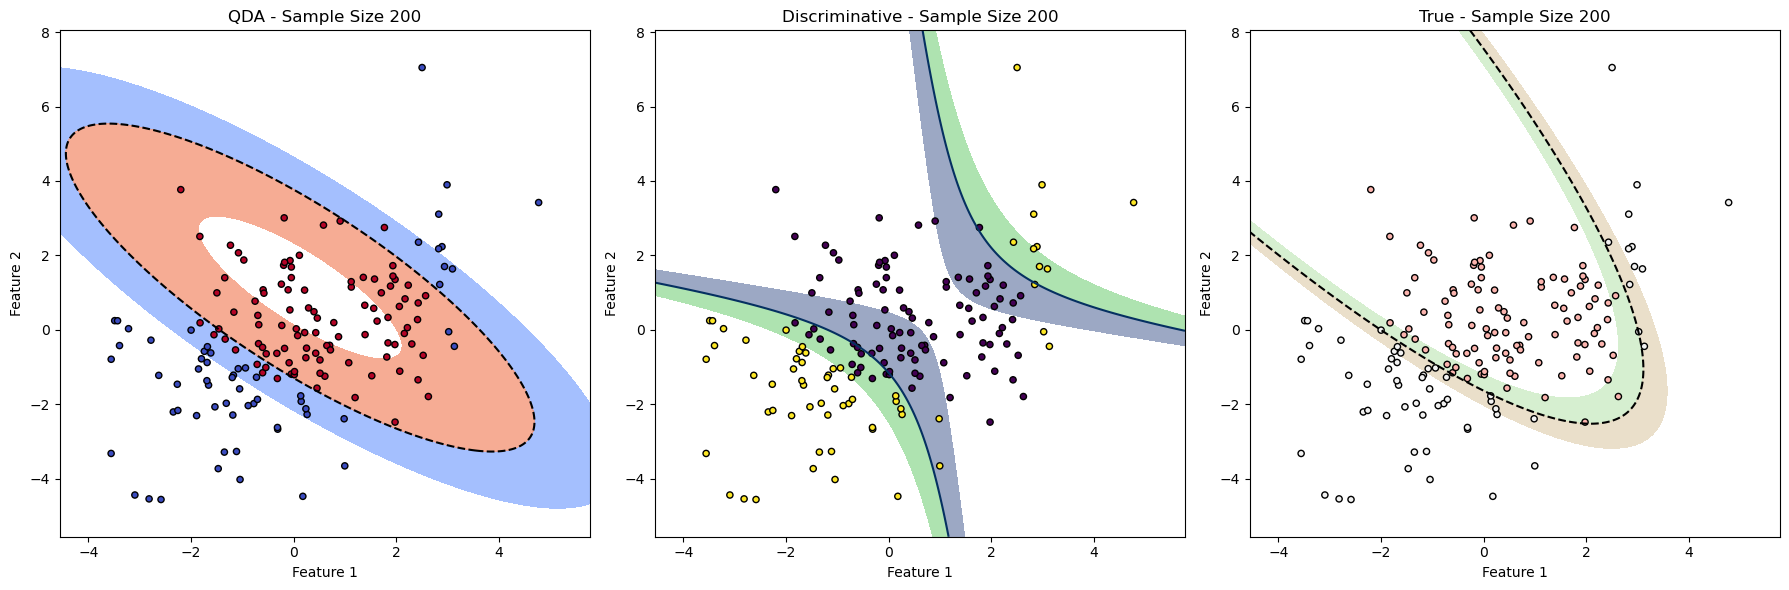

Plotting decision boundaries for sample size 500


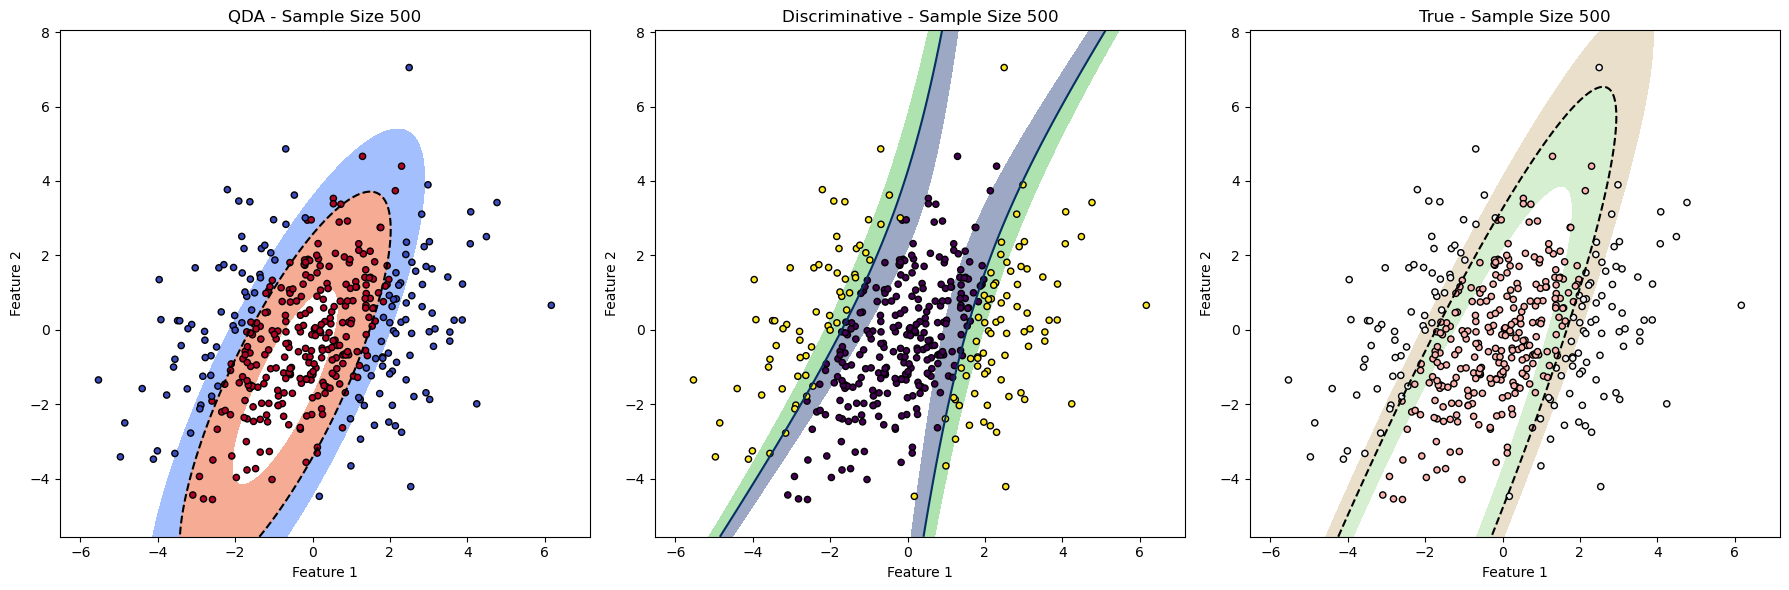

Plotting decision boundaries for sample size 1000


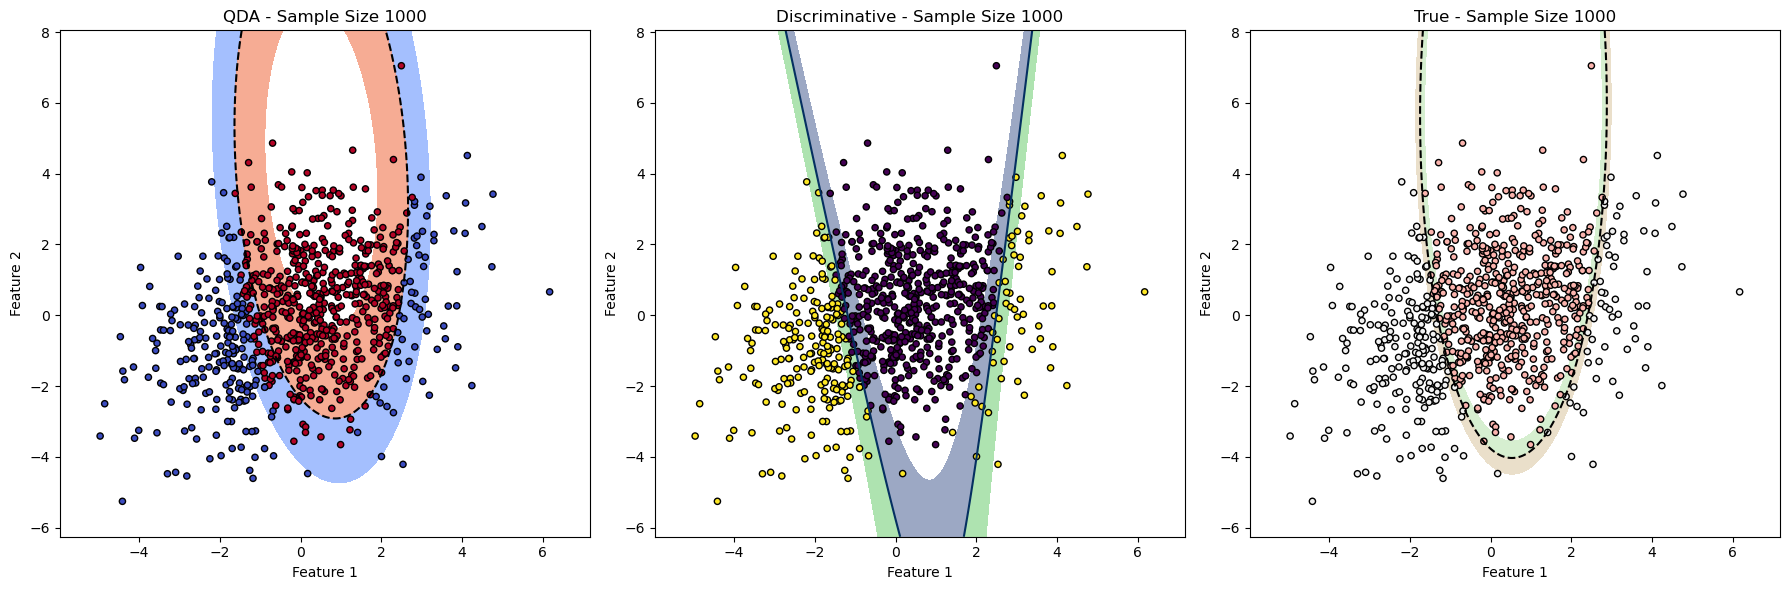

In [10]:
sample_sizes = [100, 200, 500, 1000]
results = []
seeds = [41, 121, 451, 781, 1011]

for n in sample_sizes:
    avg_errors_disc_train, avg_errors_disc_test, avg_errors_qda_train, avg_errors_qda_test = [], [], [], []
    
    # Initialize a flag to control the plotting
    plotted = False
    
    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        errors_disc_train, errors_disc_test, errors_qda_train, errors_qda_test = [], [], [], []

        for i in range(5):  # Train 5 times with different splits but same initial seed setup
            x, y, A_True, B_True, c_True = generate_data(n)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
            
            # Discriminative model training and evaluation
            A, B, C, error_history = train_discriminative_model(x_train, y_train)
            error_disc_train = evaluate_model(x_train, y_train, A, B, C)
            error_disc_test = evaluate_model(x_test, y_test, A, B, C)
            errors_disc_train.append(error_disc_train)
            errors_disc_test.append(error_disc_test)

            # QDA training and evaluation
            qda_model = ManualQDA()
            qda_model.fit(x_train, y_train)
            error_qda_train, error_qda_test = train_and_evaluate_manual_qda(x_train, y_train, x_test, y_test)
            errors_qda_train.append(error_qda_train)
            errors_qda_test.append(error_qda_test)
            
            if seed == seeds[0] and i == 0 and not plotted:
                print(f"Plotting decision boundaries for sample size {n}")
                def disc_model_predict(mesh_points):
                    return torch.sum((mesh_points @ A) * mesh_points, dim=1) + (mesh_points @ B + C).squeeze()
            
                plot_decision_boundaries(qda_model, disc_model_predict, x_train, y_train, A_True, B_True, title=f"Sample Size {n}")
                plotted = True  # Set the flag to true after plotting

        avg_errors_disc_train.append(np.mean(errors_disc_train))
        avg_errors_disc_test.append(np.mean(errors_disc_test))
        avg_errors_qda_train.append(np.mean(errors_qda_train))
        avg_errors_qda_test.append(np.mean(errors_qda_test))

    results.append((n, np.mean(avg_errors_disc_train), np.mean(avg_errors_disc_test), 
                    np.mean(avg_errors_qda_train), np.mean(avg_errors_qda_test)))

## Results Summary and Visualization
We summarize the results by displaying the average misclassification error for both the discriminative model and QDA across different sample sizes. Additionally, we will visualize the results.

Sample Size: 100, Avg Misclassification Error (Disc Train): 0.1295, Avg Misclassification Error (Disc Test): 0.1340, Avg Misclassification Error (QDA Train): 0.0775, Avg Misclassification Error (QDA Test): 0.0980
Sample Size: 200, Avg Misclassification Error (Disc Train): 0.0962, Avg Misclassification Error (Disc Test): 0.1340, Avg Misclassification Error (QDA Train): 0.0750, Avg Misclassification Error (QDA Test): 0.0950
Sample Size: 500, Avg Misclassification Error (Disc Train): 0.0476, Avg Misclassification Error (Disc Test): 0.0540, Avg Misclassification Error (QDA Train): 0.0790, Avg Misclassification Error (QDA Test): 0.0740
Sample Size: 1000, Avg Misclassification Error (Disc Train): 0.0246, Avg Misclassification Error (Disc Test): 0.0270, Avg Misclassification Error (QDA Train): 0.0790, Avg Misclassification Error (QDA Test): 0.0776


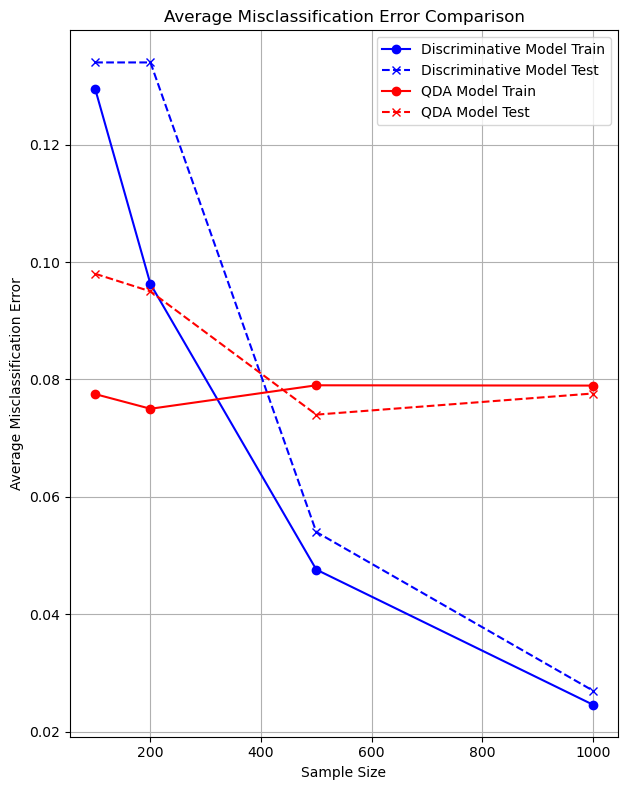

In [11]:
# Output results
for result in results:
    print(f"Sample Size: {result[0]}, Avg Misclassification Error (Disc Train): {result[1]:.4f}, "
          f"Avg Misclassification Error (Disc Test): {result[2]:.4f}, "
          f"Avg Misclassification Error (QDA Train): {result[3]:.4f}, "
          f"Avg Misclassification Error (QDA Test): {result[4]:.4f}")

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Average Misclassification Error Comparison')
plt.plot(sample_sizes, [r[1] for r in results], label='Discriminative Model Train', marker='o', color='blue')
plt.plot(sample_sizes, [r[2] for r in results], label='Discriminative Model Test', linestyle='--', marker='x', color='blue')
plt.plot(sample_sizes, [r[3] for r in results], label='QDA Model Train', marker='o', color='red')
plt.plot(sample_sizes, [r[4] for r in results], label='QDA Model Test', linestyle='--', marker='x', color='red')
plt.xlabel('Sample Size')
plt.ylabel('Average Misclassification Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Conclusion
In this notebook, we compared the performance of a discriminative model and a manually implemented QDA on data generated from a single Gaussian distribution. We evaluated their misclassification errors across different sample sizes and visualized the decision boundaries. The results provide insights into the differences between these models and their applicability in various scenarios.